# Query Construction

把用户问题 → 结构化查询对象，让我们可以：

- 一部分用于向量相似检索（transcript/title 的语义搜索）

- 一部分用于元数据过滤（发布时间、播放量、视频长度等范围条件）

这基本对应 LangChain 常说的 self-query / query analysis 思路：
“自然语言 → 查询语义 + 过滤条件”。

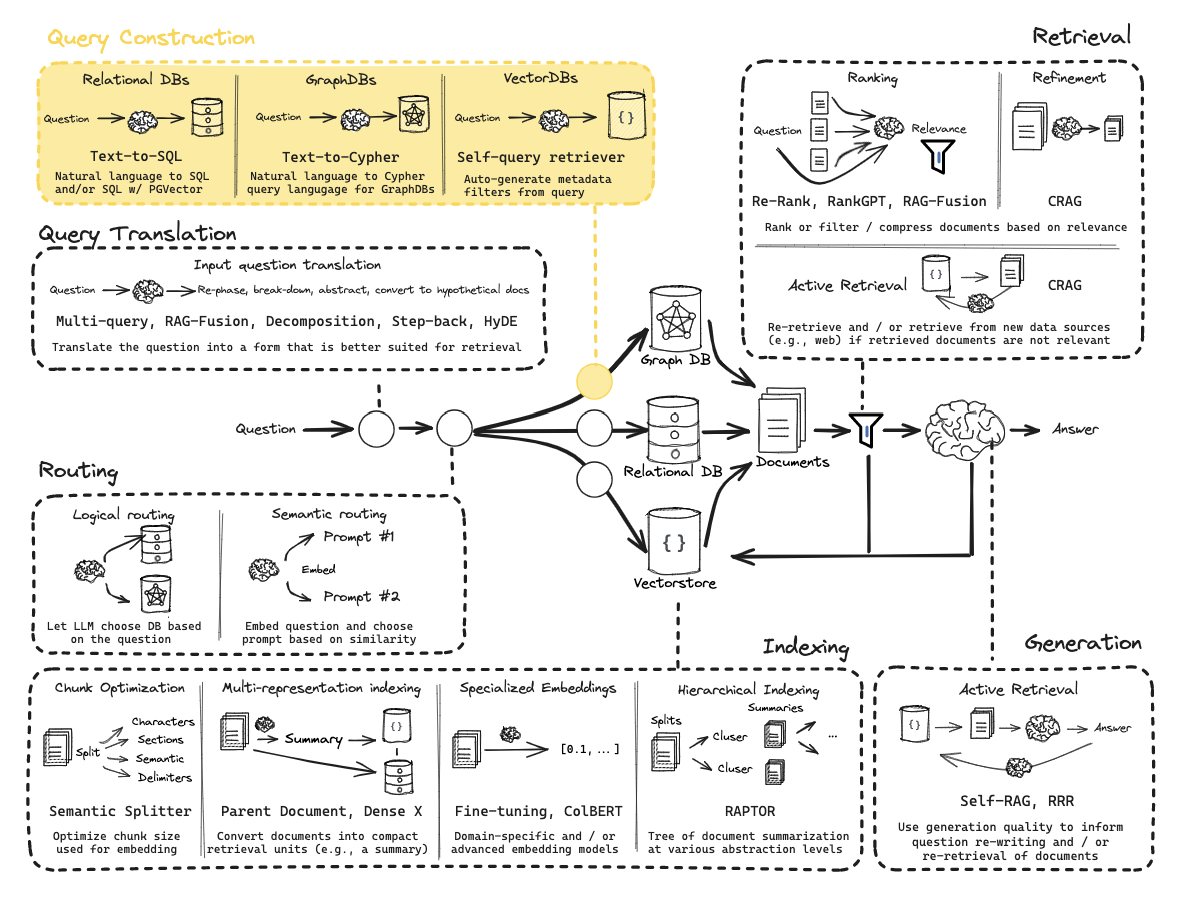

### ❌ 我们现在可能在做的事（很常见）

用户说一句话：

> **“2023 年发布的、5 分钟以内的 LangChain 教学视频”**

我们直接这样做：

```python
embedding("2023 年发布的、5 分钟以内的 LangChain 教学视频")
→ 向量检索
```

### 结果会怎样？

向量模型会把下面这些**本来是“条件”的东西**：

* “2023 年”
* “5 分钟以内”

当成 **语义的一部分**，而不是“筛选规则”。

👉 后果：

* 有的视频讲 LangChain 很相关，但发布时间是 2022 → 被错过
* 有的视频是 30 分钟 → 仍然被召回
* 检索结果“看起来能用”，但**不稳定、不精确**

---

### 核心思想（超级重要）

> ❗ **向量检索 ≠ 数据库查询**

向量检索只擅长一件事：

> “这段文本和那个文本像不像？”

它 **不擅长**：

* 年份范围
* 数字大小
* 时间长度
* before / after / greater than

👉 **所以必须把一句话拆成两部分：**

> **“2023 年发布的、5 分钟以内的 LangChain 教学视频”**

### ① 语义查询（给 embedding 用）

```text
"LangChain 教学视频"
```

### ② 结构化过滤条件（给数据库用）

```json
{
  "published_after": "2023-01-01",
  "published_before": "2023-12-31",
  "max_length_seconds": 300
}
```

### 现在我们进入一个完整、真实的例子

---

场景：我们有一个「视频教程搜索系统」

我们的视频库里，每个视频有：

<mark>文本内容（用于语义检索）</mark>

* 标题
* 字幕内容

<mark>元数据（用于过滤）</mark>

* 发布时间
* 视频时长
* 播放量
* 作者

---

**例子 1：最简单的（不需要过滤）**

用户说：

> **“rag from scratch”**

我们需要判断：

* 用户 **没有** 提到时间 / 时长 / 数字
* 那就**只做语义检索**

👉 输出大概是：

```json
{
  "content_search": "rag from scratch",
  "title_search": "rag from scratch",
  "filters": null
}
```

---

**例子 2：有时间条件**

用户说：

> **“2023 年发布的 chat langchain 视频”**

我们需要把它变成 👇

```json
{
  "content_search": "chat langchain",
  "title_search": "chat langchain",
  "published_after": "2023-01-01",
  "published_before": "2023-12-31"
}
```

---

**例子 3：数字条件（向量模型完全不擅长的部分）**

用户说：

> **“只要 5 分钟以内的 multimodal agent 教学视频”**

我们需要把它变成 👇

```json
{
  "content_search": "multimodal agent tutorial",
  "max_length_seconds": 300
}
```

---

**例子 4：多个条件混在一句话里**

用户说：

> **“2022 年之后发布、播放量高、10 分钟以内的 LangChain 视频”**

我们需要把它变成 👇

```json
{
  "content_search": "LangChain tutorial",
  "published_after": "2022-01-01",
  "min_view_count": 10000,
  "max_length_seconds": 600
}
```

---

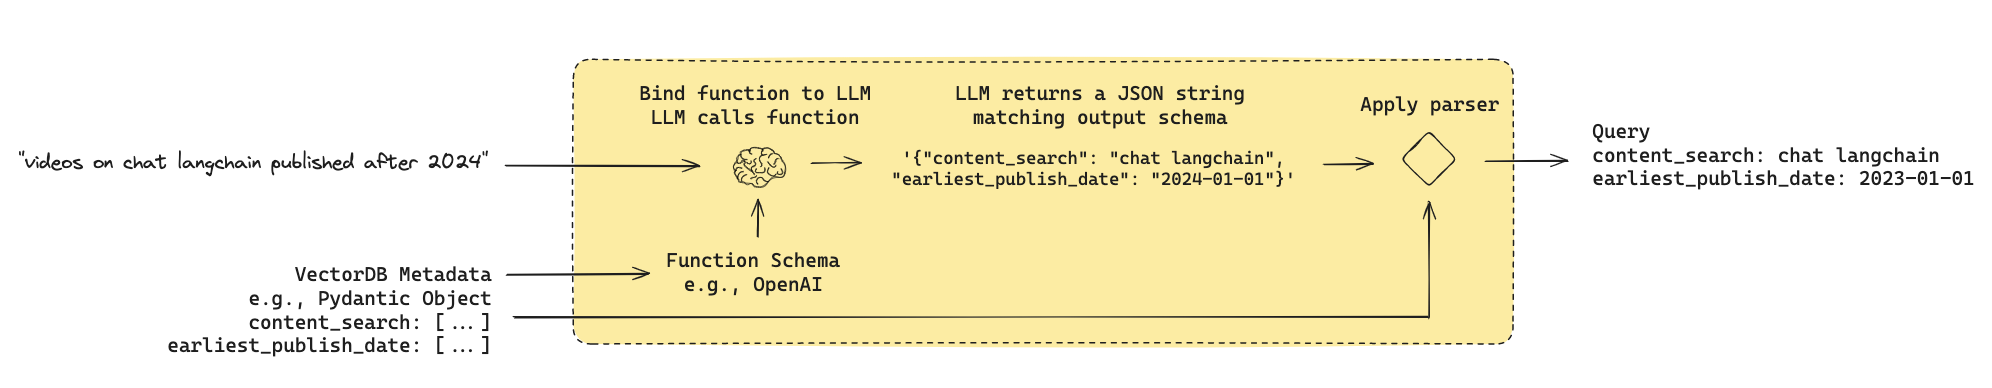

In [ ]:
# ! pip install youtube-transcript-api pytube

In [ ]:
from langchain_community.document_loaders import YoutubeLoader

docs = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=pbAd8O1Lvm4", add_video_info=True
).load()

docs[0].metadata

- docs[0].page_content 通常是字幕/文本

- docs[0].metadata 会包含视频信息（标题、发布日期、时长、观看数等，具体字段取决于 loader 返回）

假设我们建了一个“视频教程库”，支持两类能力

- 对 contents（字幕）和 title 做非结构化检索（通常就是向量检索）

- 对 view count、publication date、length 做范围过滤（range filter）

In [8]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL")

In [ ]:
import datetime
from typing import Optional
from pydantic import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to vedio transcripts."
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
        ),
    )
    min_view_count: Optional[int] = Field(
        None,
        # 最低浏览量筛选条件（含最低浏览量）。仅在明确指定时使用。
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )

    def pretty_print(self) -> None:
        # 获取该模型定义的所有字段（Field）
        # field: 字段的名称（字符串），如 "content_search"
        # field_info: 包含该字段元数据的对象，比如在定义时写的 description 或 default 值
        for field, field_info in type(self).model_fields.items():
            value = getattr(self, field)

            if value is not None and value != field_info.default:
                print(f"{field}: {value}")

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

In [11]:
query_analyzer.invoke({"question": "rag from scratch"}).pretty_print()

content_search: retrieve-and-generate RAG from scratch building RAG from scratch implementing RAG end-to-end create RAG system step-by-step vector store embeddings chunking documents context retrieval
title_search: RAG from scratch


In [12]:
query_analyzer.invoke(
    {"question": "videos on chat langchain published in 2023"}
).pretty_print()

content_search: chat langchain
title_search: chat langchain
earliest_publish_date: 2023-01-01
latest_publish_date: 2024-01-01


In [13]:
query_analyzer.invoke(
    {"question": "videos that are focused on the topic of chat langchain that are published before 2024"}
).pretty_print()

content_search: chat langchain OR "Chat" AND "LangChain" OR "chat-langchain" OR "LangChain chat" focusing on building chat applications with LangChain, chat models, chat agents, conversational chains, ChatModel usage, ChatMessage, chat-oriented prompts
title_search: chat langchain
latest_publish_date: 2024-01-01


In [14]:
query_analyzer.invoke(
    {
        "question": "how to use multi-modal models in an agent, only videos under 5 minutes"
    }
).pretty_print()

content_search: multi-modal model agent how to use multi-modal models in an agent, multimodal agent, vision+text agent, image input agent, multimodal tool usage
title_search: multi-modal agent
max_length_sec: 300
